# Time Series Mini-Poject

### This project will explore and forcast the average temperature for Los Angeles, CA

In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta, datetime

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env as ev

import warnings
warnings.filterwarnings("ignore")

#### Project Goals: 
The goal of this mini-project is to practice what I have learned at each stage of the pipeline throughout the time series module. Use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. Select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. Then model those patterns to forecast temperature into the future.

- Link to the Data: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [2]:
# Importing the csv that contains temperature data for major cities
city_wx = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [3]:
city_wx.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [4]:
# Creating a new dataframe for Los Angeles weather
la_wx = city_wx[city_wx.City =='Los Angeles']

In [5]:
la_wx.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W
131847,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W
131848,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W
131849,1849-04-01,13.704,2.902,Los Angeles,United States,34.56N,118.70W
131850,1849-05-01,14.834,2.017,Los Angeles,United States,34.56N,118.70W


In [6]:
# Converting average temperature from Celsius to Fahrenheit
la_wx['avg_temp_f'] = la_wx.AverageTemperature * 1.8 + 32

In [7]:
la_wx.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742
131847,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W,49.2386
131848,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W,53.2652
131849,1849-04-01,13.704,2.902,Los Angeles,United States,34.56N,118.70W,56.6672
131850,1849-05-01,14.834,2.017,Los Angeles,United States,34.56N,118.70W,58.7012


In [8]:
la_wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 131846 to 133822
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             1977 non-null   object 
 1   AverageTemperature             1977 non-null   float64
 2   AverageTemperatureUncertainty  1977 non-null   float64
 3   City                           1977 non-null   object 
 4   Country                        1977 non-null   object 
 5   Latitude                       1977 non-null   object 
 6   Longitude                      1977 non-null   object 
 7   avg_temp_f                     1977 non-null   float64
dtypes: float64(3), object(5)
memory usage: 139.0+ KB


In [9]:
la_wx.dt = pd.to_datetime(la_wx.dt)

In [10]:
la_wx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1977 entries, 131846 to 133822
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             1977 non-null   datetime64[ns]
 1   AverageTemperature             1977 non-null   float64       
 2   AverageTemperatureUncertainty  1977 non-null   float64       
 3   City                           1977 non-null   object        
 4   Country                        1977 non-null   object        
 5   Latitude                       1977 non-null   object        
 6   Longitude                      1977 non-null   object        
 7   avg_temp_f                     1977 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 139.0+ KB


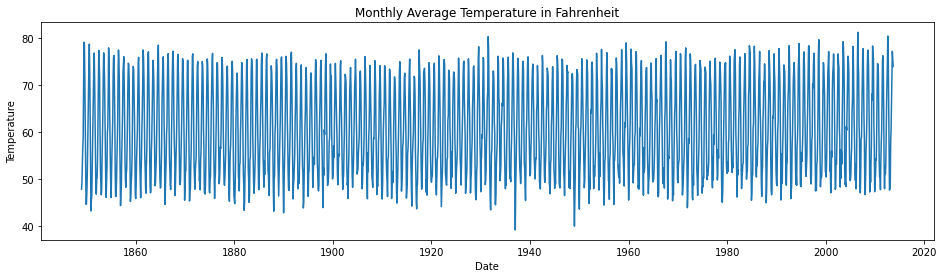

In [11]:
# Plot of the tempuratures
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=la_wx)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()

### Data Split

In [12]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(la_wx) * .5)

# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(la_wx) * .3)

# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(la_wx) - train_size - validate_size)

# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

# split into train, validation, test
train = la_wx[: train_size]
validate = la_wx[train_size : validate_end_index]
test = la_wx[validate_end_index :]

In [13]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(la_wx)

True

In [14]:
# test the row starts
pd.concat([train.head(1), la_wx.head(1)])

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742


In [15]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133426,1980-09-01,21.074,0.321,Los Angeles,United States,34.56N,118.70W,69.9332
133427,1980-10-01,18.243,0.730,Los Angeles,United States,34.56N,118.70W,64.8374


In [16]:
# compare the last row of test to last row of df
pd.concat([test.tail(1), la_wx.tail(1)])

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133822,2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W,73.9418
133822,2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W,73.9418


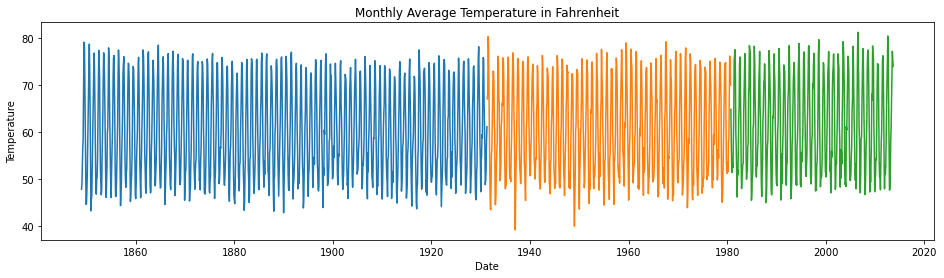

In [17]:
# plot the data points, color by train, validate, test
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()

In [18]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df =pd.DataFrame(columns = ['model_type', 'target_variable', 'rmse'])

In [19]:
eval_df

,model_type,target_variable,rmse


In [20]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals. 
    It will return the rmse, an integer. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [21]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    takes a model type as a str. The Target variable as a str.
    Runs the evaluate() function to compute rmse.
    Appends the information. Returns new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type],
        'target_variable': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

### Forecast

##### Simple Average

In [22]:
temps = round(train['avg_temp_f'].mean(), 2)


def make_predictions(temps):
    yhat_df = pd.DataFrame({'avg_temp_f': [temps]}, index = validate.dt)
    return yhat_df

In [23]:
yhat_df = make_predictions(temps)
yhat_df.head(2)

,avg_temp_f
dt,
1931-05-01,60.15
1931-06-01,60.15


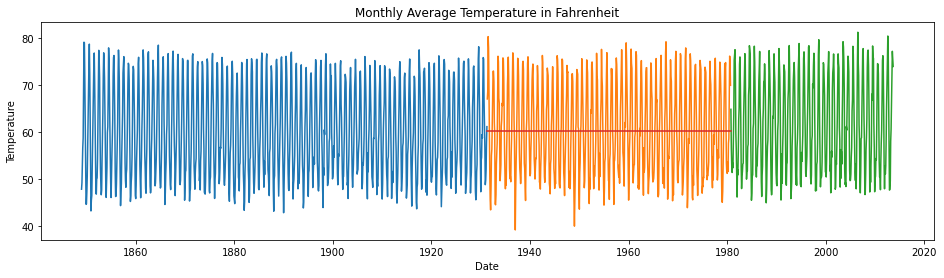

In [24]:
# plot the data points, color by train, validate, test
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)
sns.lineplot(x="dt", y="avg_temp_f", data=yhat_df)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')

plt.show()

In [25]:
eval_df = append_eval_df(model_type = 'Simple Average', target_var = 'avg_temp_f')

In [26]:
eval_df

,model_type,target_variable,rmse
0,Simple Average,avg_temp_f,10.0


### Predict Based on Previous Cycle
Weather is cyclical annually; therefore, I will use the previous cycle method next.

In [27]:
la_wx[la_wx.dt.dt.year == 2013]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133814,2013-01-01,8.813,0.651,Los Angeles,United States,34.56N,118.70W,47.8634
133815,2013-02-01,9.804,0.319,Los Angeles,United States,34.56N,118.70W,49.6472
133816,2013-03-01,14.463,0.727,Los Angeles,United States,34.56N,118.70W,58.0334
133817,2013-04-01,15.921,0.539,Los Angeles,United States,34.56N,118.70W,60.6578
133818,2013-05-01,19.028,0.531,Los Angeles,United States,34.56N,118.70W,66.2504
133819,2013-06-01,22.434,0.416,Los Angeles,United States,34.56N,118.70W,72.3812
133820,2013-07-01,25.090,0.334,Los Angeles,United States,34.56N,118.70W,77.1620
133821,2013-08-01,24.232,0.384,Los Angeles,United States,34.56N,118.70W,75.6176
133822,2013-09-01,23.301,0.984,Los Angeles,United States,34.56N,118.70W,73.9418


In [28]:
# Resplit
    # Train: first date through 1972
train = la_wx.loc[:133333]
    # Validate is 1973 through 1992 (20 yrs)
validate = la_wx.loc[133334: 133573]
    # Test is 1993 through 2013 (20 yrs)
test = la_wx.loc[133574:]

In [29]:
train

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
131846,1849-01-01,8.819,2.558,Los Angeles,United States,34.56N,118.70W,47.8742
131847,1849-02-01,9.577,1.970,Los Angeles,United States,34.56N,118.70W,49.2386
131848,1849-03-01,11.814,2.173,Los Angeles,United States,34.56N,118.70W,53.2652
131849,1849-04-01,13.704,2.902,Los Angeles,United States,34.56N,118.70W,56.6672
131850,1849-05-01,14.834,2.017,Los Angeles,United States,34.56N,118.70W,58.7012
...,...,...,...,...,...,...,...,...
133329,1972-08-01,23.965,0.553,Los Angeles,United States,34.56N,118.70W,75.1370
133330,1972-09-01,20.678,0.465,Los Angeles,United States,34.56N,118.70W,69.2204
133331,1972-10-01,15.809,0.656,Los Angeles,United States,34.56N,118.70W,60.4562
133332,1972-11-01,11.280,0.378,Los Angeles,United States,34.56N,118.70W,52.3040


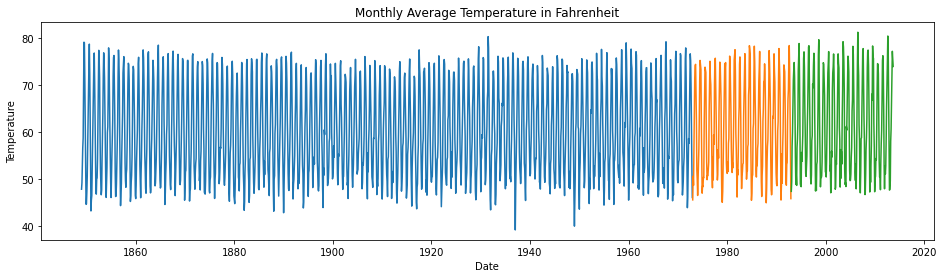

In [30]:
# plot the data points, color by train, validate, test
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()

In [31]:
# Last year in train 
train[train.dt.dt.year == 1972]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133322,1972-01-01,7.915,0.477,Los Angeles,United States,34.56N,118.70W,46.2470
133323,1972-02-01,11.409,0.391,Los Angeles,United States,34.56N,118.70W,52.5362
133324,1972-03-01,14.790,0.584,Los Angeles,United States,34.56N,118.70W,58.6220
133325,1972-04-01,14.224,0.325,Los Angeles,United States,34.56N,118.70W,57.6032
133326,1972-05-01,17.541,0.354,Los Angeles,United States,34.56N,118.70W,63.5738
133327,1972-06-01,21.243,0.653,Los Angeles,United States,34.56N,118.70W,70.2374
133328,1972-07-01,24.788,0.562,Los Angeles,United States,34.56N,118.70W,76.6184
133329,1972-08-01,23.965,0.553,Los Angeles,United States,34.56N,118.70W,75.1370
133330,1972-09-01,20.678,0.465,Los Angeles,United States,34.56N,118.70W,69.2204
133331,1972-10-01,15.809,0.656,Los Angeles,United States,34.56N,118.70W,60.4562


In [32]:
# Average yearly temperature difference
train.avg_temp_f.diff(12).mean()

0.003617073170731721

In [33]:
# take the values for each day in 1972 and add the average yoy (y/y) difference to be our forecast for 1973. 
# yhat_df = pd.DataFrame(columns = ['index', 'temp'])
yhat_df = train.avg_temp_f[train.dt.dt.year == 1953] + train.avg_temp_f.diff(12).mean()
for i in range(1,20):
    yhat_df = yhat_df.append(train.avg_temp_f[train.dt.dt.year == (1953+i)] + train.avg_temp_f.diff(12).mean())

In [34]:
train[train.dt.dt.year == 1953]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,avg_temp_f
133094,1953-01-01,11.592,0.393,Los Angeles,United States,34.56N,118.70W,52.8656
133095,1953-02-01,10.313,0.474,Los Angeles,United States,34.56N,118.70W,50.5634
133096,1953-03-01,11.250,0.171,Los Angeles,United States,34.56N,118.70W,52.2500
133097,1953-04-01,12.700,0.427,Los Angeles,United States,34.56N,118.70W,54.8600
133098,1953-05-01,14.593,1.071,Los Angeles,United States,34.56N,118.70W,58.2674
133099,1953-06-01,18.248,0.693,Los Angeles,United States,34.56N,118.70W,64.8464
133100,1953-07-01,24.853,0.298,Los Angeles,United States,34.56N,118.70W,76.7354
133101,1953-08-01,22.223,0.418,Los Angeles,United States,34.56N,118.70W,72.0014
133102,1953-09-01,21.721,0.417,Los Angeles,United States,34.56N,118.70W,71.0978
133103,1953-10-01,16.987,0.364,Los Angeles,United States,34.56N,118.70W,62.5766


In [35]:
yhat_df.head(30)

133094    52.869217
133095    50.567017
133096    52.253617
133097    54.863617
133098    58.271017
133099    64.850017
133100    76.739017
133101    72.005017
133102    71.101417
133103    62.580217
133104    56.372017
133105    50.304217
133106    47.692417
133107    55.482817
133108    50.547217
133109    59.174617
133110    63.951817
133111    67.125217
133112    77.574217
133113    71.799817
133114    69.724417
133115    61.790017
133116    57.122617
133117    48.680617
133118    44.499217
133119    47.832817
133120    53.574817
133121    54.552217
133122    60.697417
133123    66.587017
Name: avg_temp_f, dtype: float64

In [36]:
# set yhat_df to index of validate
yhat_df = pd.DataFrame(yhat_df)
yhat_df = yhat_df.set_index(validate.index)

In [37]:
yhat_df = yhat_df.join(validate.dt)

In [38]:
yhat_df.head(40)

,avg_temp_f,dt
133334,52.869217,1973-01-01
133335,50.567017,1973-02-01
133336,52.253617,1973-03-01
133337,54.863617,1973-04-01
133338,58.271017,1973-05-01
133339,64.850017,1973-06-01
133340,76.739017,1973-07-01
133341,72.005017,1973-08-01
133342,71.101417,1973-09-01
133343,62.580217,1973-10-01


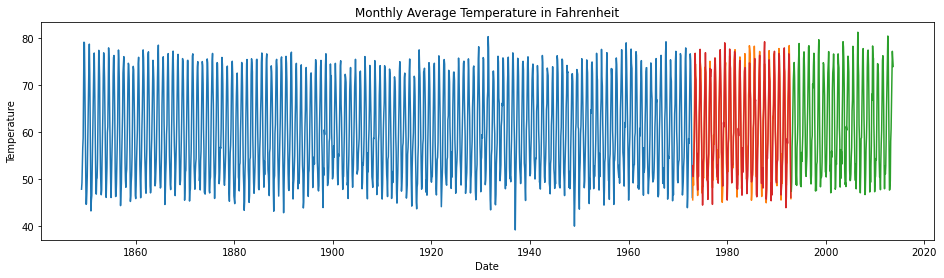

In [39]:
# plot the data points, color by train, validate, test, yhat
plt.figure(figsize=(16, 4))
sns.lineplot(x="dt", y="avg_temp_f", data=train)
sns.lineplot(x="dt", y="avg_temp_f", data=validate)
sns.lineplot(x="dt", y="avg_temp_f", data=test)
sns.lineplot(x="dt", y="avg_temp_f", data=yhat_df)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Monthly Average Temperature in Fahrenheit')
plt.show()

In [40]:
eval_df = append_eval_df(model_type = 'Previous Cycle', target_var = 'avg_temp_f')

In [41]:
eval_df

,model_type,target_variable,rmse
0,Simple Average,avg_temp_f,10.0
1,Previous Cycle,avg_temp_f,3.0


### Initial Conclusions
Using a previous cycle of 20 years plus the yearly average temperature difference produced much better result compared to a simple average. Going forward I plan to use a monthly average cycle (by creating a new df with the average temperature for each month from train) then adding the average temperature difference to project forward. This would likely achieve better results overall; however, it would not be a good predictor for months/years where the temperature is abnormally hotter or colder that normal. 